In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import warnings
warnings.filterwarnings('ignore')

2024-08-14 23:09:10.273132: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-14 23:09:10.285324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 23:09:10.302292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 23:09:10.302318: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 23:09:10.312776: I tensorflow/core/platform/cpu_feature_gua

In [2]:
import torch
#torch.multiprocessing.set_start_method('spawn')
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
import torch.nn.utils as nn_utils
from tqdm.auto import tqdm
from gpzoo.gp import SVGP, VNNGP
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import NSF2
from gpzoo.utilities import rescale_spatial_coords, dims_autocorr, regularized_nmf, add_jitter, scanpy_sizefactors, deviancePoisson, anndata_to_train_val #init_softplus
import gpzoo.pri_experiment_utilities as exp
import squidpy as sq
import numpy as np
import time
import random
import scanpy as sc
import anndata as ad
from anndata import AnnData
from squidpy.gr import spatial_neighbors, spatial_autocorr
from sklearn.cluster import KMeans
from os import path
from copy import deepcopy
from scipy import sparse
from contextlib import suppress
from scanpy import read_h5ad
from tensorflow import constant
from tensorflow.data import Dataset
import tensorflow as tf
from sklearn.decomposition import NMF

In [3]:
import gpzoo.pri_experiment_utilities as putil

In [4]:
random.seed(256)
root_path = '/engelhardt/home/pshrestha/vnngp/'
dpath = path.join(root_path, "data/crc_data")

dpth = path.join(root_path, "data/")
mpth = path.join(root_path, "models/")
rpth = path.join(root_path, "results/")
crc_path = path.join(rpth, "crc/")

In [5]:
print("CUDA available: ", torch.cuda.is_available())
print("Number of GPUs: ", torch.cuda.device_count())
print("Current GPU: ", torch.cuda.current_device())
print("GPU Name: ", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available:  True
Number of GPUs:  2
Current GPU:  0
GPU Name:  NVIDIA A30


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
def center_data(Dtr_n,Dval_n=None):
  Dtr_c = deepcopy(Dtr_n)
  feature_means=Dtr_c["Y"].mean(axis=0)
  Dtr_c["Y"] -= feature_means
  if Dval_n:
    Dval_c = deepcopy(Dval_n)
    Dval_c["Y"] -= feature_means
  else:
    Dval_c = None
  return feature_means,Dtr_c,Dval_c

def prepare_datasets_tf(Dtrain,Dval=None,shuffle=False,batch_size=None):
  """
  Dtrain and Dval are dicts containing numpy np.arrays of data.
  Dtrain must contain the key "Y"
  Returns a from_tensor_slices conversion of Dtrain and a dict of tensors for Dval
  """
  Ntr = Dtrain["Y"].shape[0]
  if batch_size is None:
    #ie one batch containing all observations by default
    batch_size = Ntr
  else:
    batch_size = minibatch_size_adjust(Ntr,batch_size)
  Dtrain = Dataset.from_tensor_slices(Dtrain)
  if shuffle:
    Dtrain = Dtrain.shuffle(Ntr)
  Dtrain = Dtrain.batch(batch_size)
  if Dval is not None:
    Dval = {i:constant(Dval[i]) for i in Dval}
  return Dtrain, Ntr, Dval

def scanpy_sizefactors(Y):
  sz = Y.sum(axis=1,keepdims=True)
  return sz/np.median(sz)

In [8]:
def heatmap(X,y,figsize=(6,4),bgcol="gray",cmap="turbo",**kwargs):
  fig,ax=plt.subplots(figsize=figsize)
  ax.set_facecolor(bgcol)
  ax.scatter(X[:,0],X[:,1],c=y,cmap=cmap,**kwargs)
  # fig.show()

In [9]:
name = 'adata_SN048_A121573_Rep2.h5ad'
spath = path.join(dpath, name)
#print("vnngp/data/crc_data/adata_SN048_A121573_Rep2.h5ad")
#print(spath)

In [10]:
ad = sc.read_h5ad(spath)

In [11]:
X = np.array(ad.obs[['x_array', 'y_array']])
print(X.shape)

ad.obsm['spatial'] = X

(2291, 2)


In [12]:
Y_sums = np.array(np.sum(ad.X > 0, axis=0))[0]
    
Y = np.array(ad.X[:, Y_sums>100].todense(), dtype=int).T
Y_dense = np.array(ad.X.todense(), dtype=int).T

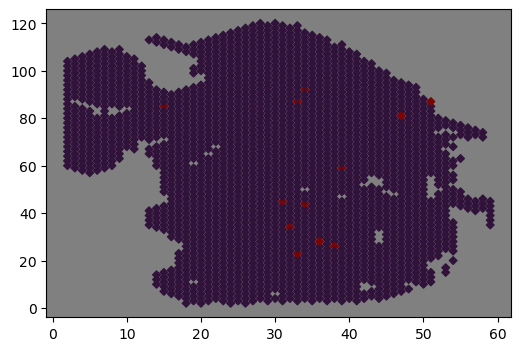

In [13]:
heatmap(X, Y.T[:,0],marker="D",s=15)

In [13]:
ad.var["mt"] = ad.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(ad, qc_vars=["mt"], inplace=True)
ad = ad[ad.obs.pct_counts_mt < 20]
sc.pp.filter_genes(ad, min_cells=1)
sc.pp.filter_cells(ad, min_counts=100)
ad.layers = {"counts":ad.X.copy()} #store raw counts before normalization changes ad.X
ad.layers = {"counts":ad.X.copy()}

In [14]:
#sc.pp.normalize_total(ad, inplace=True, layers=None, key_added="sizefactor") #normalized total counts per cell to a common value
#sc.pp.log1p(ad) # performs a log transformation to the data

In [15]:
ad.var['deviance_poisson'] = deviancePoisson(ad.layers["counts"])
o = np.argsort(-ad.var['deviance_poisson'])
idx = list(range(ad.shape[0]))
random.shuffle(idx)
ad = ad[idx,o]

Dtr_n['X'] shape: (2176, 2)
Dtr_n['Y'] shape: (2176, 17022)
Dtr['X'] shape: (2176, 2)
Dtr['Y'] shape: (2176, 17022)


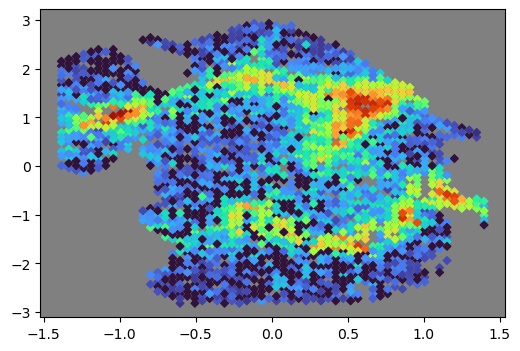

In [16]:
Dtr,Dval = anndata_to_train_val(ad,layer="counts",sz="scanpy")
Dtr_n,Dval_n = anndata_to_train_val(ad) #normalized data

fmeans, Dtr_c, Dval_c = center_data(Dtr_n,Dval_n) #centered features
Xtr = Dtr["X"] #note this should be identical to Dtr_n["X"]
Ntr = Xtr.shape[0]

print(f"Dtr_n['X'] shape: {Dtr_n['X'].shape}")
print(f"Dtr_n['Y'] shape: {Dtr_n['Y'].shape}")

print(f"Dtr['X'] shape: {Dtr['X'].shape}")
print(f"Dtr['Y'] shape: {Dtr['Y'].shape}")

Dtf = prepare_datasets_tf(Dtr,Dval=Dval,shuffle=False)
Dtf_n = prepare_datasets_tf(Dtr_n,Dval=Dval_n,shuffle=False)
Dtf_c = prepare_datasets_tf(Dtr_c,Dval=Dval_c,shuffle=False)

heatmap(Xtr,Dtr_n["Y"][:,0],marker="D",s=15)

In [17]:
Dtr_n["Y"].mean()

0.21028328

In [18]:
Dtr["Y"].mean()

0.21028328

In [19]:
L = [10]
max_iter = 1000
#crc_nmf_path = path.join(crc_path, "nmf")

In [20]:
Dtr_n["Y"].shape

(2176, 17022)

In [21]:
Y.shape

(12190, 2291)

In [22]:
nmf_model = NMF(n_components=5, max_iter=100, init='nndsvd', random_state=0, alpha_H=2e-1, alpha_W=1e-7)

In [23]:
nmf_model.fit(Dtr_n["Y"])

NMF(alpha_H=0.2, alpha_W=1e-07, init='nndsvd', max_iter=100, n_components=5,
    random_state=0)

In [24]:
exp_factors = nmf_model.transform(Dtr_n["Y"])
factors = np.log(exp_factors + 1e-2)
loadings = nmf_model.components_.T

In [25]:
moran_idx, moranI = putil.dims_autocorr(np.exp(factors), Dtr["X"])

In [26]:
factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

In [27]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):
    max_val = np.percentile(factors, 95)
    min_val = np.percentile(factors, 5)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
        
    for i in range(L):
        plt.subplot(L//5, 5, i+1)
        
        curr_ax = ax[i%5]
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [28]:
len(np.exp(factors_ordered).T)

5

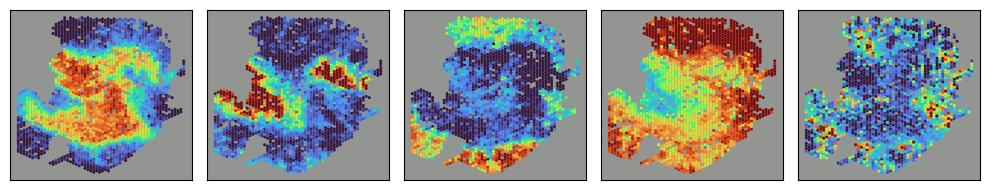

In [29]:
##### Check initialization
size=2
fig, axes = plt.subplots(1, 5, figsize=(size*5, size*1), tight_layout=True)
plot_factors(np.exp(factors_ordered).T, Dtr["X"], moran_idx=None, size=2, s=1.5, alpha=0.9, ax=axes)

In [31]:
factors.shape

(2176, 5)

In [30]:
#L = [10]
#M = [100]
#K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#K = [1, 5, 10, 20]
K = [8]
lkzz_builds = [1]
#sigmas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
sigmas = [0.1]
lengthscales = [0.7]

In [31]:
steps = 2000
model_type = 'VNNGP'
batched = True
save_path = path.join(root_path, "results/crc/nnnsf")

In [32]:
X = torch.tensor(Dtr["X"], dtype=torch.float)
Y = torch.tensor(Dtr["Y"].T, dtype=torch.float)

In [33]:
print(X.shape)
print(Y.shape)

torch.Size([2176, 2])
torch.Size([17022, 2176])


In [34]:
print(factors.shape)
print(loadings.shape)

(2176, 5)
(17022, 5)


In [40]:
for k in K:
    for s in sigmas:
        for l in lengthscales:
            dicts = {
                'L': 5, 
                'M': 2176, 
                'K': 8,
                'sigma': s, 
                'lengthscale': l, 
                'jtr': 1e-1,
                'batch_size': 128,
                'lr': 1e-3,
                'rs': 256,
                'lkzz_build': 1,
                'model': 'VNNGP',
                'L1_jitter' : 1e-3,
            }
            
            factors = np.array(factors)
            loadings = np.array(loadings)
            
            kwargs = dicts
            file_path = model_type
            #X, Y = data_func()
            #K=None
            if model_type == 'VNNGP':
                file_path += f"_K={kwargs['K']}"
            
                if kwargs['lkzz_build']:
                    file_path += f"_lkzz={kwargs['lkzz_build']}"
                    
            file_path += f"_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}_iter={steps}"
            if batched:
                file_path += f"_bs={kwargs['batch_size']}"
                
            if NMF:
                # with NMF initialization
                file_path += f"_NMFinit"
                X_array = np.array(X.cpu())
                Y_array = np.array(Y.cpu())
                moran_idx, moranI = putil.dims_autocorr(factors, X_array)
                factors=factors[:, moran_idx]
                loadings=loadings[:, moran_idx]
                model = putil.build_model(X_array, Y_array, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)
                    
            #model = build_model(X, Y, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)
            putil.model_grads(model)
            model.prior.jitter=kwargs['jtr']
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
                
            model.to(device)
            X = torch.tensor(X).type(torch.float)
            Y = torch.tensor(Y).type(torch.float)
            X_train = X.to(device)
            #Y_train = Y.to(device)
                
            start_time = time.time()
            X = torch.tensor(X, dtype=torch.float).to(device)
            Y = torch.tensor(Y, dtype=torch.float).to(device)
            losses, means, scales, idxs = putil.train_batched(model, optimizer, X_train, Y, device,
                                                        steps=steps, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)
            del X
            del Y
            end_time = time.time()
                
            final_time = end_time - start_time
                
            #torch.save(model.state_dict(), f'{save_path}/{file_path}_state_dict.pth')
            #torch.save({'losses': losses,
                        #'means': means,
                        #'scales': scales,
                        #'time': final_time},
                         #f'{save_path}/{file_path}_model.pt')
            
            #print('sigmas:', model.prior.kernel.sigma)
            #print('lengthscale:', model.prior.kernel.lengthscale)
            
            fig, ax = plt.subplots()
            ax.plot(losses)
            fig.suptitle(f"{model_type} Loss | sigma: {kwargs['sigma']}, lengthscale: {kwargs['lengthscale']}")
            plt.show()
            #fig.savefig(f'{save_path}/{file_path}_loss.png')
            #fig.close()
            
            #size=2
            #fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
                
            model.cpu()
            qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
            mean = torch.exp(qF.mean).detach().numpy()
            plot_factors(np.exp(mean), X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=1.2, alpha=0.9, ax=axes)

            #plot_factors(np.exp(mean), X.cpu().detach().numpy(), moran_idx=None, size=2, s=1.2, alpha=0.9, ax=axes)
            #fig.suptitle(f'Factors | sigma: {kwargs["sigma"]}, lengthscale: {kwargs["lengthscale"]}')
            #fig.savefig(f'{save_path}/{file_path}_plot.png')
            #fig.close()

OutOfMemoryError: CUDA out of memory. Tried to allocate 92.00 MiB (GPU 0; 23.60 GiB total capacity; 90.84 MiB already allocated; 86.69 MiB free; 94.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# Define the number of kernels
kernel = model.prior.cpu().Lu.detach().numpy()
num_kernels = kernel.shape[0]
vmin = np.min(kernel)
vmax = np.max(kernel)

# Calculate the grid size
cols = 5
rows = (num_kernels + cols - 1) // cols  # Ensures enough rows for all kernels
cmap = plt.cm.viridis_r

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

# Plot each kernel
for i in range(num_kernels):
    ax = axes[i % cols]
    im = ax.imshow(kernel[i], vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_title(f'Kernel {i+1}')
    #fig.colorbar(im, ax=ax)
    ax.axis('off')

# Hide any empty subplots
for j in range(num_kernels, rows * cols):
    axes[j // cols, j % cols].axis('off')

fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.15, 0.35, 0.7, 0.02])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
plt.tight_layout()

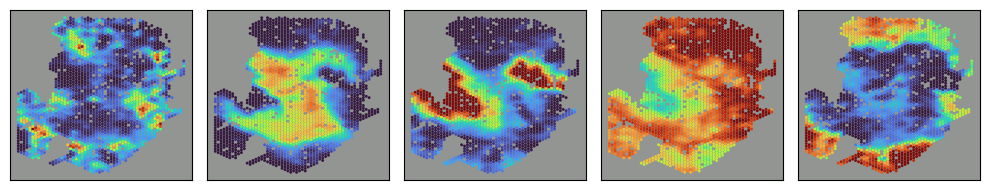

In [39]:
# FACTORS AFTER 12000 TRAINING STEPS
size=2
fig, axes = plt.subplots(1, 5, figsize=(size*5, size*1), tight_layout=True)
plot_factors(mean, X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=1.2, alpha=0.9, ax=axes)
                
#model.cpu()
#qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
#mean = torch.exp(qF.mean).detach().numpy()
#plot_factors(np.exp(mean), X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=1.2, alpha=0.9, ax=axes)
#fig.suptitle(f'Factors | sigma: {kwargs["sigma"]}, lengthscale: {kwargs["lengthscale"]}')
#fig.savefig(f'{save_path}/{file_path}_plot.png')

In [40]:
print(mean.shape)
print(len(scales))

(5, 2176)
18


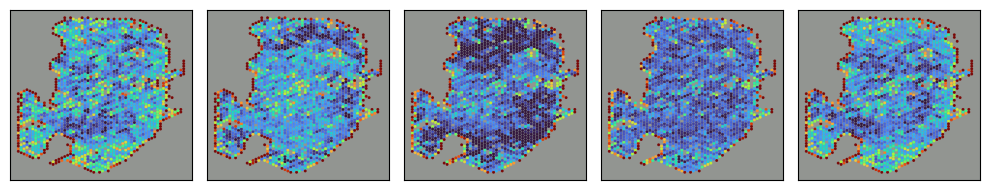

In [41]:
# SCALES AFTER 12000 TRAINING STEPS
size=2
scales = torch.nn.functional.softplus(qF.scale.detach().cpu()).numpy()
fig, axes = plt.subplots(1, 5, figsize=(size*5, size*1), tight_layout=True)
plot_factors(scales, X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=1.2, alpha=0.9, ax=axes)

In [9]:
name = 'adata_SN048_A121573_Rep1.h5ad'
spath = path.join(dpath, name)

In [10]:
ad = sc.read_h5ad(spath)

In [11]:
X = np.array(ad.obs[['x_array', 'y_array']])
print(X.shape)

ad.obsm['spatial'] = X

(2052, 2)


In [12]:
Y_sums = np.array(np.sum(ad.X > 0, axis=0))[0]
    
Y = np.array(ad.X[:, Y_sums>100].todense(), dtype=int).T
Y_dense = np.array(ad.X.todense(), dtype=int).T

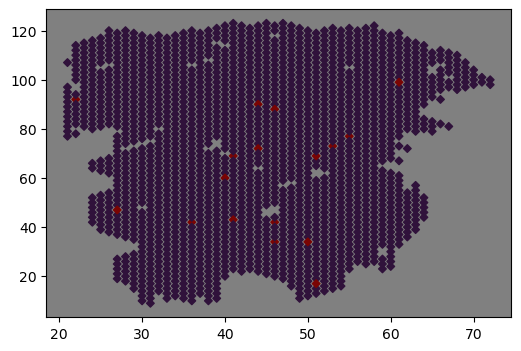

In [13]:
heatmap(X, Y.T[:,0],marker="D",s=15)

In [14]:
ad.var["mt"] = ad.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(ad, qc_vars=["mt"], inplace=True)
ad = ad[ad.obs.pct_counts_mt < 20]
sc.pp.filter_genes(ad, min_cells=1)
sc.pp.filter_cells(ad, min_counts=100)
ad.layers = {"counts":ad.X.copy()} #store raw counts before normalization changes ad.X
ad.layers = {"counts":ad.X.copy()}

ad.var['deviance_poisson'] = deviancePoisson(ad.layers["counts"])
o = np.argsort(-ad.var['deviance_poisson'])
idx = list(range(ad.shape[0]))
random.shuffle(idx)
ad = ad[idx,o]

Dtr_n['X'] shape: (1949, 2)
Dtr_n['Y'] shape: (1949, 17146)
Dtr['X'] shape: (1949, 2)
Dtr['Y'] shape: (1949, 17146)


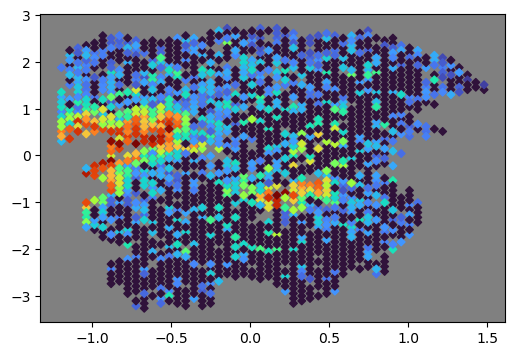

In [15]:
Dtr,Dval = anndata_to_train_val(ad,layer="counts",sz="scanpy")
Dtr_n,Dval_n = anndata_to_train_val(ad) #normalized data

fmeans, Dtr_c, Dval_c = center_data(Dtr_n,Dval_n) #centered features
Xtr = Dtr["X"] #note this should be identical to Dtr_n["X"]
Ntr = Xtr.shape[0]

print(f"Dtr_n['X'] shape: {Dtr_n['X'].shape}")
print(f"Dtr_n['Y'] shape: {Dtr_n['Y'].shape}")

print(f"Dtr['X'] shape: {Dtr['X'].shape}")
print(f"Dtr['Y'] shape: {Dtr['Y'].shape}")

Dtf = prepare_datasets_tf(Dtr,Dval=Dval,shuffle=False)
Dtf_n = prepare_datasets_tf(Dtr_n,Dval=Dval_n,shuffle=False)
Dtf_c = prepare_datasets_tf(Dtr_c,Dval=Dval_c,shuffle=False)

heatmap(Xtr,Dtr_n["Y"][:,0],marker="D",s=15)

In [16]:
nmf_model = NMF(n_components=5, max_iter=100, init='nndsvd', random_state=0, alpha_H=2e-1, alpha_W=1e-7)

In [17]:
nmf_model.fit(Dtr_n["Y"])

NMF(alpha_H=0.2, alpha_W=1e-07, init='nndsvd', max_iter=100, n_components=5,
    random_state=0)

In [18]:
exp_factors = nmf_model.transform(Dtr_n["Y"])
factors = np.log(exp_factors + 1e-2)
loadings = nmf_model.components_.T
moran_idx, moranI = putil.dims_autocorr(np.exp(factors), Dtr["X"])

In [19]:
factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

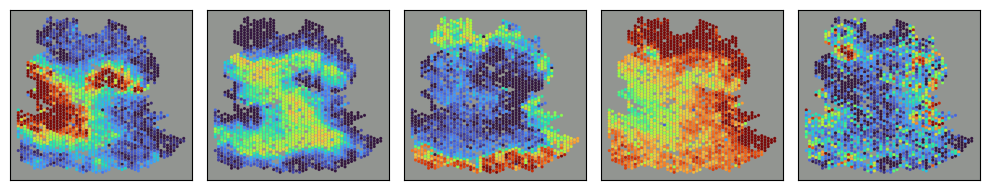

In [22]:
##### Check initialization
size=2
fig, axes = plt.subplots(1, 5, figsize=(size*5, size*1), tight_layout=True)
plot_factors(np.exp(factors_ordered).T, Dtr["X"], moran_idx=None, size=2, s=1.5, alpha=0.9, ax=axes)

In [23]:
K = [8]
lkzz_builds = [1]
sigmas = [1.0]
lengthscales = [0.1]

In [24]:
steps = 2000
model_type = 'VNNGP'
batched = True
save_path = path.join(root_path, "results/crc/nnnsf")

In [25]:
X = torch.tensor(Dtr["X"], dtype=torch.float)
Y = torch.tensor(Dtr["Y"].T, dtype=torch.float)

In [26]:
print(X.shape)
print(Y.shape)

torch.Size([1949, 2])
torch.Size([17146, 1949])


In [33]:
torch.cuda.empty_cache()

In [35]:
for k in K:
    for s in sigmas:
        for l in lengthscales:
            dicts = {
                'L': 5, 
                'M': 1000, 
                'K': 8,
                'sigma': s, 
                'lengthscale': l, 
                'jtr': 1e-1,
                'batch_size': 8,
                'lr': 1e-3,
                'rs': 256,
                'lkzz_build': 1,
            }
            
            factors = np.array(factors)
            loadings = np.array(loadings)
            
            kwargs = dicts
            file_path = model_type
            #X, Y = data_func()
            #K=None
            if model_type == 'VNNGP':
                file_path += f"_K={kwargs['K']}"
            
                if kwargs['lkzz_build']:
                    file_path += f"_lkzz={kwargs['lkzz_build']}"
                    
            file_path += f"_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}_iter={steps}"
            if batched:
                file_path += f"_bs={kwargs['batch_size']}"
                
            if NMF:
                # with NMF initialization
                file_path += f"_NMFinit"
                X_array = np.array(X.cpu())
                Y_array = np.array(Y.cpu())
                moran_idx, moranI = putil.dims_autocorr(factors, X_array)
                factors=factors[:, moran_idx]
                loadings=loadings[:, moran_idx]
                model = putil.build_model(X_array, Y_array, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)
                    
            #model = build_model(X, Y, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)
            putil.model_grads(model)
            model.prior.jitter=kwargs['jtr']
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
                
            model.to(device)
            X = torch.tensor(X).type(torch.float)
            Y = torch.tensor(Y).type(torch.float)
            X_train = X.to(device)
            #Y_train = Y.to(device)
                
            start_time = time.time()
            X = torch.tensor(X, dtype=torch.float).to(device)
            Y = torch.tensor(Y, dtype=torch.float).to(device)
            losses, means, scales, idxs = putil.train_batched(model, optimizer, X_train, Y, device,
                                                        steps=steps, E=3, batch_size=kwargs['batch_size'], kwargs=kwargs)
            end_time = time.time()
                
            final_time = end_time - start_time
                
            #torch.save(model.state_dict(), f'{save_path}/{file_path}_state_dict.pth')
            #torch.save({'losses': losses,
                        #'means': means,
                        #'scales': scales,
                        #'time': final_time},
                         #f'{save_path}/{file_path}_model.pt')
            
            #print('sigmas:', model.prior.kernel.sigma)
            #print('lengthscale:', model.prior.kernel.lengthscale)
            
            fig, ax = plt.subplots()
            ax.plot(losses)
            fig.suptitle(f"{model_type} Loss | sigma: {kwargs['sigma']}, lengthscale: {kwargs['lengthscale']}")
            plt.show()
            #fig.savefig(f'{save_path}/{file_path}_loss.png')
            #fig.close()
            
            #size=2
            #fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
                
            model.cpu()
            qF, _, _ = model.prior(X.cpu(), kwargs=kwargs)
            mean = torch.exp(qF.mean).detach().numpy()
            #plot_factors(np.exp(mean), X.cpu().detach().numpy(), moran_idx=moran_idx, size=2, s=1.2, alpha=0.9, ax=axes)

            #plot_factors(np.exp(mean), X.cpu().detach().numpy(), moran_idx=None, size=2, s=1.2, alpha=0.9, ax=axes)
            #fig.suptitle(f'Factors | sigma: {kwargs["sigma"]}, lengthscale: {kwargs["lengthscale"]}')
            #fig.savefig(f'{save_path}/{file_path}_plot.png')
            #fig.close()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
